## Explore and Process Original Dataset

- Lead
    - Before test the model, it is necessary to explore and process the original dataset, including eliminate some variables, transform the variables' form to a more readable one, group variables, etc. In a word, we need to finsih the feature engineering part before deploy the model to the dataset.
    - Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. which also is the fundamental to the application of machine learning.
- Anslysis
    - Load the data and explore the dataset
    - Remove some variables and cateogrize the variables
- Python code: Attached below

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data and explore the dataset
data = pd.read_csv("~/Desktop/L/Anomaly Detection/session 2/HW2/XYZloan_default_selected_vars.csv")


In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=42)

In [4]:
train.shape

(48000, 89)

In [5]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0,int64
Unnamed: 0.1,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object
AP006,object


In [6]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [7]:
var.columns = ['varname','dtype'] 
var.head()

,varname,dtype
0,Unnamed: 0,int64
1,Unnamed: 0.1,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [8]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0,int64,Un
1,Unnamed: 0.1,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [9]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [10]:
# "AP004" is a bad data field and should be removed.
# remove the variables that have more than 99% NAs
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [11]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

- Conclusion
    - In the following analysis, we will use random forest and GBM. That is to say, we don't need to deal with the missing values and I just remove AP004 and group the variable into several groups.

## H2O

In [12]:
# start h2o
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/gaealee/opt/anaconda3/envs/working/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/hw/q8mxlsgj3453glj5g4wm2bsc0000gn/T/tmpy3cms781
  JVM stdout: /var/folders/hw/q8mxlsgj3453glj5g4wm2bsc0000gn/T/tmpy3cms781/h2o_gaealee_started_from_python.out
  JVM stderr: /var/folders/hw/q8mxlsgj3453glj5g4wm2bsc0000gn/T/tmpy3cms781/h2o_gaealee_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,10 days
H2O cluster name:,H2O_from_python_gaealee_t16f5v
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [13]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [14]:
target='loan_default'

### Random Forest

- Lead:
    - Random forest is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mdoe of the classes (classification) or mean prediction (regression) of the individual trees
    - We can run the random forest in the h2o and the strength of this method includes reduce variance with minimal increase in bias, while the weakness is slow to score and lack of transparency.
    -  Since it is time-costly to use whole dataset to run the model, it is practical to use a sample of dataset first.
    - To get the optimal hyperparameter, we can use grid(hyperparameter) search in python. There are two approaches, including grid search and random grid search
    - The meaning of some parameters:
        - Max_depth: Maximum tree depth.
        - min_rows: Fewest allowed (weighted) observations in a leaf.
        - mtries: Number of variables randomly sampled as candidates at each split. If set to -1, defaults to sqrt{p} for classification and p/3 for regression (where p is the # of predictors
        - ntrees: Number of trees.
        - nfolds: Number of folds for K-fold cross-validation (0 to disable or >= 2).
- Analysis
    - Choose the sample data and split the data into train and test
    - Run the random forest model in H2o and use grid search method to find the best hyperparameter.
    - Examine the variable importantce, get the gains table and ROC curve to determine if the hyperparameter is appropriate in this model.
    - Choose the final hyperparameters which have the best result of gains table and ROC curve.
- Python code: Attached below

In [15]:
# split the sample dataset
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [16]:
predictors =  CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [17]:
# build the random forest model with the sample data
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300, #it will take 300 subsetals to create 300 trees
        nfolds=10,   # cross-validation
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |███████████████████████████████████████████████| 100%


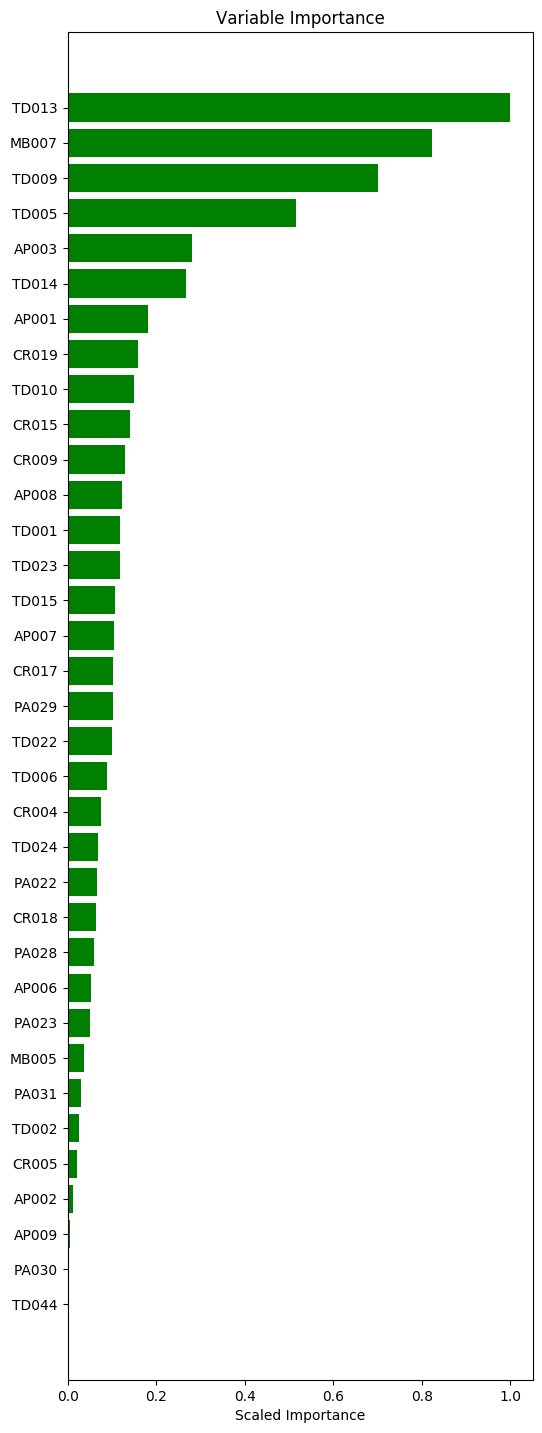

In [18]:
# create the function of variable importance
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

# get the variable importance with hyperparameters in the example    
VarImp(rf_v1)

In [19]:
# create the function of gains table
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)
# get the gains table with the example hyperparameters
createGains(rf_v1)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,100,220,320,100,220,0.17,0.08,60.0,1.67,9.0,31.25
1,320,83,237,640,183,457,0.30,0.18,120.0,1.52,12.0,28.59
2,320,84,236,960,267,693,0.44,0.27,180.0,1.48,17.0,27.81
3,320,58,262,1280,325,955,0.54,0.37,240.0,1.35,17.0,25.39
4,320,70,250,1600,395,1205,0.66,0.46,300.0,1.32,20.0,24.69
5,320,48,272,1920,443,1477,0.74,0.57,360.0,1.23,17.0,23.07
6,320,42,278,2240,485,1755,0.81,0.68,420.0,1.15,13.0,21.65
7,320,51,269,2560,536,2024,0.89,0.78,480.0,1.12,11.0,20.94
8,320,41,279,2880,577,2303,0.96,0.89,540.0,1.07,7.0,20.03


In [20]:
# create the function of roc and auc cruve
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



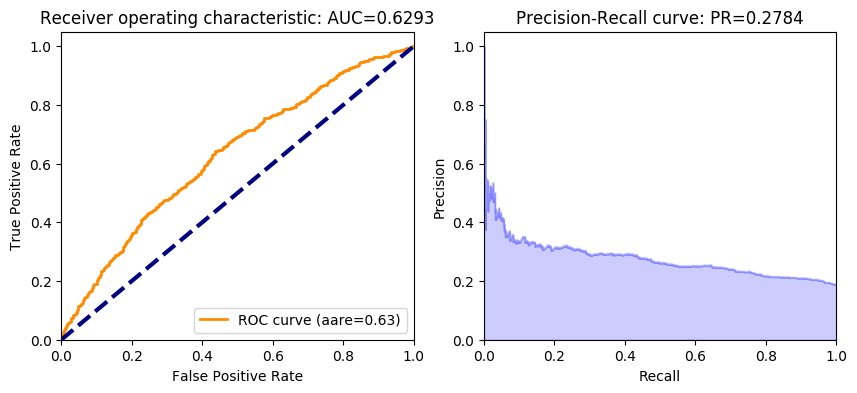

In [21]:
# plot the roc and auc cruve for the example 
ROC_AUC(rf_v1,test_hex,'loan_default')

## Grid(hyperparameter) search

In [22]:
# tune hyperparameters search
from h2o.grid.grid_search import H2OGridSearch
estimator = H2ORandomForestEstimator(
    # Stops fitting new trees when 10-tree rolling average is within 0.00001
    stopping_rounds = 10,
    stopping_tolerance = 0.00001,
    stopping_metric = 'auto',
    score_each_iteration = True,
    balance_classes = True,
    seed = 1234)

random_params = {'ntrees':[100,150,200,300,500,800], 
                'max_depth': [20,25,30,35,40,50]}

criteria = {'strategy': "Cartesian"}


grid_search = H2OGridSearch(model = estimator, 
                            hyper_params = random_params,
                            search_criteria = criteria)

grid_search.train(predictors,target,training_frame=train_hex)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [23]:
# sort the best parameters by mse
sorted_grid = grid_search.get_grid(sort_by='mse',decreasing=False)
sorted_grid

     max_depth ntrees  \
0           20    800   
1           20    300   
2           20    500   
3           20    200   
4           25    500   
5           25    200   
6           25    300   
7           25    800   
8           35    200   
9           40    800   
10          35    800   
11          50    800   
12          40    500   
13          35    500   
14          50    500   
15          50    300   
16          50    200   
17          35    300   
18          40    200   
19          40    300   
20          30    200   
21          30    300   
22          30    800   
23          30    500   
24          20    150   
25          25    150   
26          35    150   
27          50    150   
28          40    150   
29          30    150   
30          20    100   
31          25    100   
32          40    100   
33          35    100   
34          50    100   
35          30    100   

                                                                model_ids 

### The code works fine with the small dataset, we can model with the entire dataset

In [107]:
# 
train_w = h2o.H2OFrame(train)
test_w = h2o.H2OFrame(test)
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 800,
        max_depth =20,
        min_rows=70,
        seed=1234)
rf_v2.train(predictors,target,training_frame=train_w)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


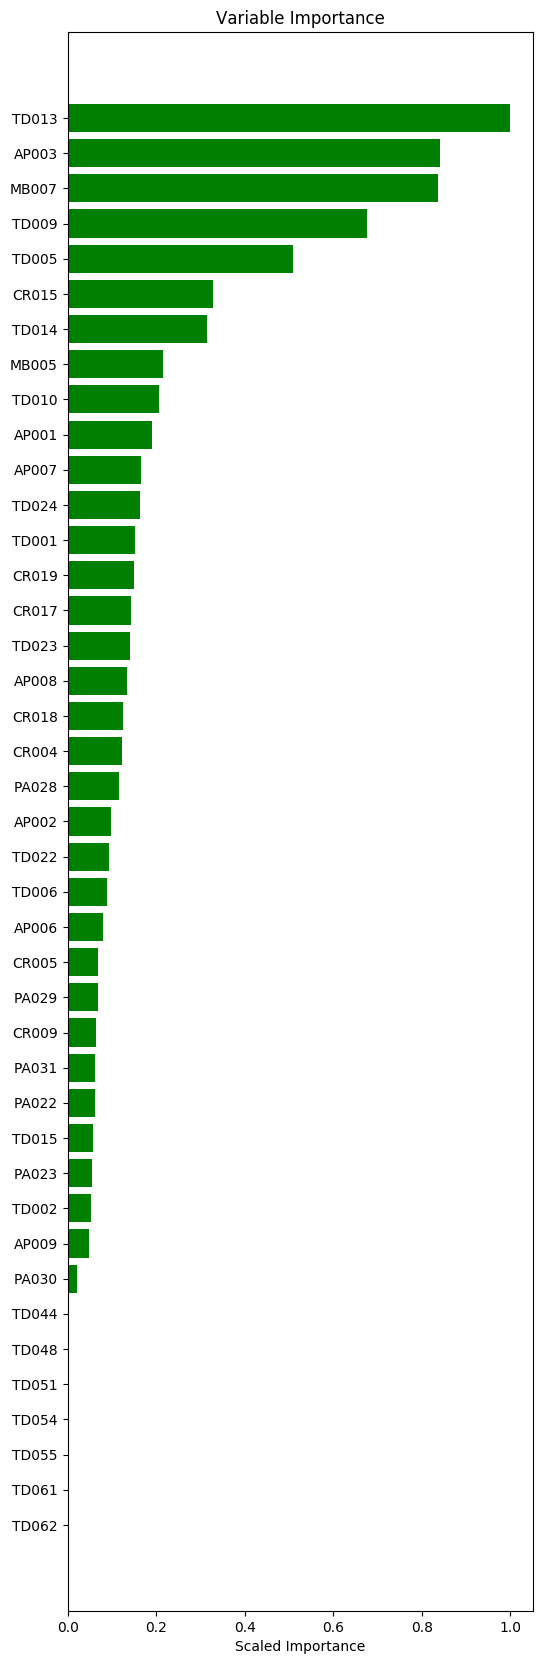

In [121]:
VarImp(rf_v2)

In [108]:
createGains(rf_v2)

drf prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,108,212,320,108,212,0.18,0.08,60.0,1.80,10.0,33.75
1,320,90,230,640,198,442,0.33,0.17,120.0,1.65,16.0,30.94
2,320,71,249,960,269,691,0.45,0.27,180.0,1.49,18.0,28.02
3,320,67,253,1280,336,944,0.56,0.36,240.0,1.40,20.0,26.25
4,320,71,249,1600,407,1193,0.68,0.46,300.0,1.36,22.0,25.44
5,320,60,260,1920,467,1453,0.78,0.56,360.0,1.30,22.0,24.32
6,320,52,268,2240,519,1721,0.86,0.66,420.0,1.24,20.0,23.17
7,320,37,283,2560,556,2004,0.93,0.77,480.0,1.16,16.0,21.72
8,320,25,295,2880,581,2299,0.97,0.88,540.0,1.08,9.0,20.17


drf prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



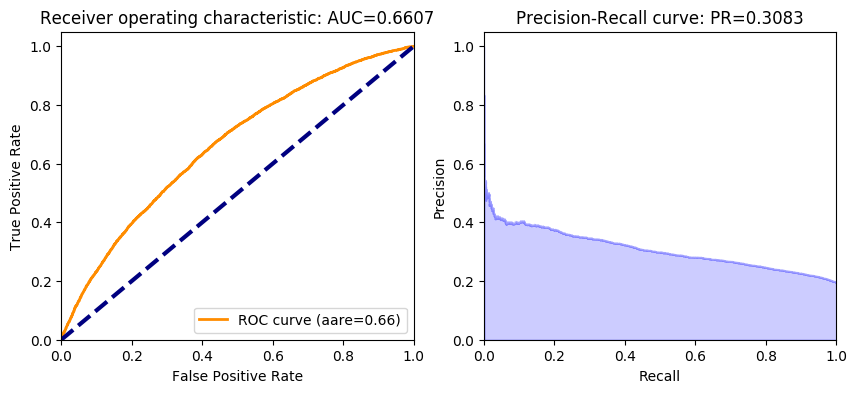

In [109]:
ROC_AUC(rf_v2,test_w,'loan_default')

- Conclusion
    - As the result shown above, the gird search method will work and I choose max_depth = 20, ntree = 800. We can see the final result of gains table looks good and the lift is 1.8. Meanwhile, the AUC also reach to 0.6607, which is much higher than the previous one.
    - In the final version of random forest model, the first three important variables are TD013, AP003, MB007.

### GBM

- Lead
    - The gradient boosting computes a sequence of weak learners (typically very simple trees), where each successive tree is built for the prediction residuals of the preceding tree.
    - The strengths of GBM is often best possible model, robust, adn directly optimizes cost function. While the weaknesses are overfit which means need to find proper stopping point, sensitive to noise and extreme values, need to set several hyperparameters and lack of transparency
    - Still better to use sample data to tune the hyperparameters and then apply the best paramaters to the whole dataset
    - Meanings of some hyper parameters:
        - learn_rate: learn_rate Learning rate (from 0.0 to 1.0)
        - max_depth: Maximum tree depth.
        - sample_rate: Row sample rate per tree (from 0.0 to 1.0)
        - col_sample_rate: Column sample rate (from 0.0 to 1.0)
- Analysis
    - Use grid search methods to find the best parameters in the sample data
    - Choose the best parameters to build the GBM model and apply to the whole dataset.
    - Use the function of variable importance, gains table, roc and auc curve to examine the model.
- Python code: Attached below

In [110]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

In [111]:
# GBM hyperparameters
gbm_params2 = {'learn_rate': [i * 0.01 for i in range(1, 11)],
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

# Train and validate a random grid of GBMs
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid2',
                          hyper_params=gbm_params2,
                          search_criteria=search_criteria)
gbm_grid2.train(predictors,target,training_frame=train_hex,validation_frame=test_hex,seed=1234)



# Get the grid results, sorted by validation AUC
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='mse', decreasing=False)
gbm_gridperf2



gbm Grid Build progress: |████████████████████████████████████████████████| 100%
          col_sample_rate learn_rate max_depth         sample_rate  \
0      0.6000000000000001       0.04         7                 0.8   
1                     0.2       0.03         7                 1.0   
2                     0.1       0.09         3                 0.9   
3                     0.2       0.06         4                 0.9   
4                     0.2        0.1         3                 0.8   
5     0.30000000000000004       0.06         2  0.7000000000000001   
6                     0.9       0.06         3                 0.8   
7                     1.0       0.07         2  0.6000000000000001   
8                     0.9       0.04         4                 0.5   
9      0.6000000000000001       0.05         4                 0.9   
10     0.7000000000000001       0.08         2                 0.5   
11                    0.2       0.06         7                 0.8   
12       

In [112]:
gbm_v1 = H2OGradientBoostingEstimator(
        model_id = 'gbm_v1',
        seed=1234,
        col_sample_rate = 0.6000000000000001, 
        learn_rate = 0.04, 
        max_depth = 7,
        sample_rate=0.8 )

gbm_v1.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


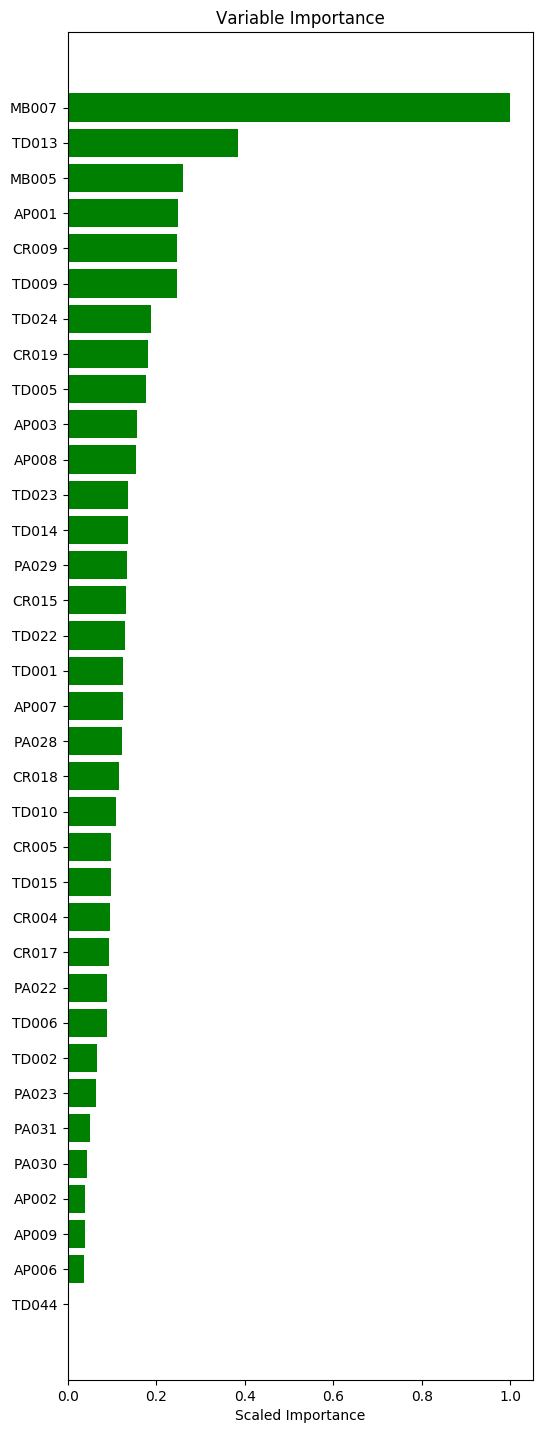

In [113]:
VarImp(gbm_v1)

In [114]:
createGains(gbm_v1)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,104,216,320,104,216,0.17,0.08,60.0,1.73,9.0,32.50
1,320,79,241,640,183,457,0.30,0.18,120.0,1.52,12.0,28.59
2,320,89,231,960,272,688,0.45,0.26,180.0,1.51,19.0,28.33
3,320,66,254,1280,338,942,0.56,0.36,240.0,1.41,20.0,26.41
4,320,58,262,1600,396,1204,0.66,0.46,300.0,1.32,20.0,24.75
5,320,55,265,1920,451,1469,0.75,0.56,360.0,1.25,19.0,23.49
6,320,49,271,2240,500,1740,0.83,0.67,420.0,1.19,16.0,22.32
7,320,45,275,2560,545,2015,0.91,0.78,480.0,1.14,13.0,21.29
8,320,27,293,2880,572,2308,0.95,0.89,540.0,1.06,6.0,19.86


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



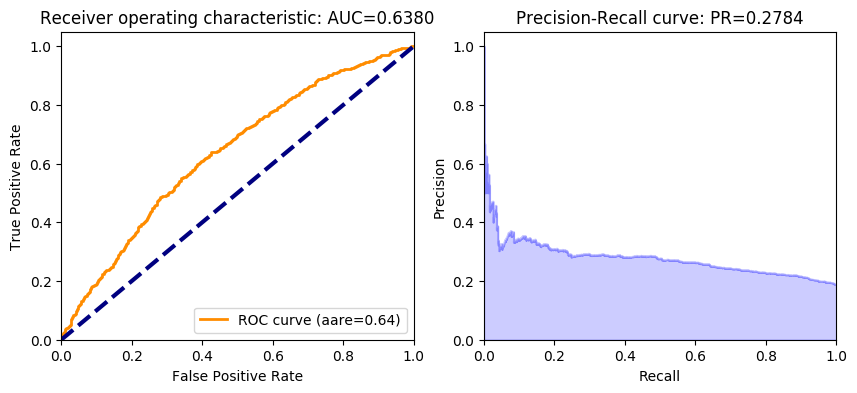

In [115]:
ROC_AUC(gbm_v1,test_hex,'loan_default')

In [119]:
# apply to the whole dataset

gbm_v1.train(predictors,target,training_frame=train_w)

# create gains table
createGains(gbm_v1)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,109,211,320,109,211,0.18,0.08,60.0,1.82,10.0,34.06
1,320,90,230,640,199,441,0.33,0.17,120.0,1.66,16.0,31.09
2,320,74,246,960,273,687,0.46,0.26,180.0,1.52,20.0,28.44
3,320,73,247,1280,346,934,0.58,0.36,240.0,1.44,22.0,27.03
4,320,62,258,1600,408,1192,0.68,0.46,300.0,1.36,22.0,25.50
5,320,57,263,1920,465,1455,0.78,0.56,360.0,1.29,22.0,24.22
6,320,51,269,2240,516,1724,0.86,0.66,420.0,1.23,20.0,23.04
7,320,43,277,2560,559,2001,0.93,0.77,480.0,1.16,16.0,21.84
8,320,22,298,2880,581,2299,0.97,0.88,540.0,1.08,9.0,20.17


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



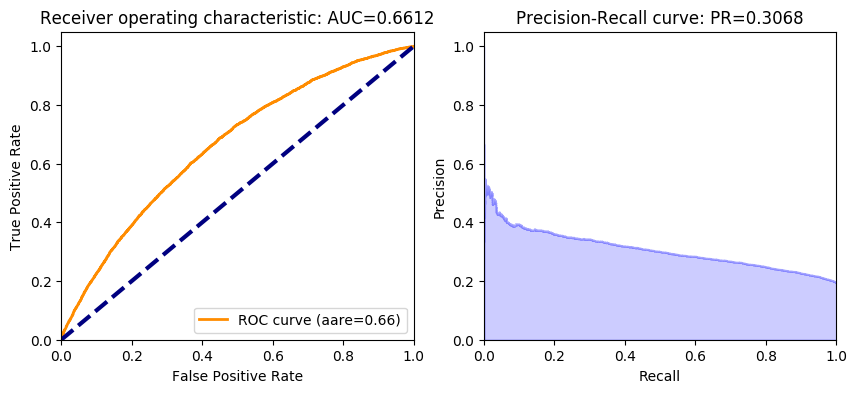

In [120]:
# get teh roc and auc curve
ROC_AUC(gbm_v1,test_w,'loan_default')

- Conclusion
    - Using the grid search, we can get the optimal parameters, that is, col_sample_rate = 0.6000000000000001, learn_rate = 0.04, max_depth = 7,sample_rate=0.8.
    - As the result shown above, with decile 0, the lift is 1.82 and the whole lift table, ROC and AUC curve looks great. We can see the result of AUC improved than the result in the sample and is 0.6612. 
    - In this model, the first three important variables are MB007, TD013, MB005

## Comparison between Random Forest and GBM

- Compare teh result of random forest and GBM, I will chose GBM with col_sample_rate = 0.6000000000000001, learn_rate = 0.04, max_depth = 7,sample_rate=0.8 to be my final model since its gains table, ROC, and AUC curve look better than the other. In other words, it has a better prediction ability.
- Both of these two models show that MB007 and TD013 are very important for the prediction result.

